## 3-unsupervised-classification

Accompanying the paper:<br>
A. J. Lundervold, ..., A. Lundervold. _Decoding IBS: A Machine Learning Approach to Psychological Distress and Gut-Brain Interaction_

Arvid Lundervold, v. 2024-07-21  - using conda kernel `ibs` (Python 3.11.9))

Last updated: 2024-07-22


**References**

[1] Steinley, Douglas. “K‐means clustering: a half‐century synthesis.” British Journal of Mathematical and Statistical Psychology 59.1 (2006): 1–34.

[2] Dueck, Delbert. Affinity propagation: clustering data by passing messages. Toronto: University of Toronto, 2009.

[3] Von Luxburg, Ulrike. “A tutorial on spectral clustering.” Statistics and computing 17.4 (2007): 395–416.

[4] Ackermann, Marcel R., et al. “Analysis of agglomerative clustering.” Algorithmica 69.1 (2014): 184–215.

[5] Derpanis, Konstantinos G. “Mean shift clustering.” Lecture Notes (2005): 32.

[6] Khan, Kamran, et al. “DBSCAN: Past, present and future.” The fifth international conference on the applications of digital information and web technologies (ICADIWT 2014). IEEE, 2014.

[7] Rousseeuw, Peter J. “Silhouettes: a graphical aid to the interpretation and validation of cluster analysis.” Journal of computational and applied mathematics 20 (1987): 53–65.

[8] Caliński, Tadeusz, and Jerzy Harabasz. “A dendrite method for cluster analysis.” Communications in Statistics-theory and Methods 3.1 (1974): 1–27.

[9] Davies, David L., and Donald W. Bouldin. “A cluster separation measure.” IEEE transactions on pattern analysis and machine intelligence 2 (1979): 224–227.

[10] Yuan, Chunhui, and Haitao Yang. “Research on K-value selection method of K-means clustering algorithm.” J 2.2 (2019): 226–235.

[11] Abdi, Hervé, and Lynne J. Williams. “Principal component analysis.” Wiley interdisciplinary reviews: computational statistics 2.4 (2010): 433–459.

- https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Clustering.ipynb

- https://towardsdatascience.com/clustering-made-easy-with-pycaret-656316c0b080

- https://towardsdatascience.com/introduction-to-clustering-in-python-with-pycaret-5d869b9714a3

### Import libraries

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pycaret
import ydata_profiling
from ydata_profiling import ProfileReport
import platform
import shutil
import warnings
import datetime
import pingouin as pg
import xgboost as xgb
from pycaret.classification import *
from pycaret.regression import *
from pycaret.clustering import *
from pycaret.anomaly import *
from sklearn.gaussian_process import GaussianProcessClassifier as gpc
from sklearn.gaussian_process.kernels import RBF

# import MLP from scikit-learn  
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.inspection import permutation_importance
import shap

home = os.path.expanduser('~')

In [4]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10/11 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install')

OK, you are running on MacOS (Darwin Kernel Version 23.5.0: Wed May  1 20:09:52 PDT 2024; root:xnu-10063.121.3~5/RELEASE_X86_64)


In [5]:
# Versions

print(f'seaborn: {sns.__version__}')
print(f'pandas: {pd.__version__}')
print(f'pycaret: {pycaret.__version__}')
print(f'ydata_profiling: {ydata_profiling.__version__}')
print(f'pingouin: {pg.__version__}')
print(f'xgboost: {xgb.__version__}')
print(f'scikit-learn: {sklearn.__version__}')
print(f'shap: {shap.__version__}')
print(f'scikit-plot: {skplt.__version__}')


seaborn: 0.13.2
pandas: 2.1.4
pycaret: 3.3.2
ydata_profiling: v4.9.0
pingouin: 0.5.4
xgboost: 2.1.0
scikit-learn: 1.4.2
shap: 0.46.0
scikit-plot: 0.3.7


### Read reduced dataset, rename columns, and inspect the data

In [7]:
# Load the CSV file
df_in = pd.read_csv('../data/BGA_for_classification_77x13.csv')

In [8]:
df_in = df_in.rename(columns = {'Category':'Group'})

In [9]:
df_in

,BGA,Sex,Age,IBS-SSS,R1,R2,B1,B2,H1,H2,F1,F2,Group
0,BGA_046,M,38.0,195.0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0,IBS
1,BGA_051,M,38.0,293.0,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0,IBS
2,BGA_057,F,30.0,264.0,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0,IBS
3,BGA_058,F,57.0,296.0,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS
4,BGA_059,F,43.0,364.0,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0,IBS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,BGA_160,F,23.0,265.0,20.0,46.0,11.0,13.0,12.0,4.0,4.0,1.0,IBS
73,BGA_161,F,21.0,393.0,35.0,51.0,0.0,3.0,8.0,1.0,5.0,2.0,IBS
74,BGA_164,F,25.0,12.0,40.0,66.0,2.0,3.0,11.0,7.0,3.0,0.0,HC
75,BGA_171,M,21.0,32.0,35.0,66.0,3.0,13.0,8.0,2.0,2.0,1.0,HC


In [10]:
# col_keep = ['Sex', 'Age', 'R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2', 'Group']
col_keep = ['R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2', 'Group']


df = df_in.copy()
df = df_in[col_keep]
df.describe()

,R1,R2,B1,B2,H1,H2,F1,F2
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,33.909091,59.701299,5.220779,9.168831,6.571429,3.753247,3.285714,1.259740
std,5.145723,8.669464,4.109115,4.985248,4.290223,3.116830,2.689439,1.408644
min,14.000000,35.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,54.000000,2.000000,5.000000,3.000000,1.000000,0.000000,0.000000
50%,35.000000,60.000000,4.000000,9.000000,6.000000,4.000000,4.000000,1.000000
75%,37.000000,66.000000,8.000000,13.000000,9.000000,6.000000,6.000000,2.000000
max,42.000000,82.000000,16.000000,21.000000,17.000000,14.000000,7.000000,4.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R1      77 non-null     float64
 1   R2      77 non-null     float64
 2   B1      77 non-null     float64
 3   B2      77 non-null     float64
 4   H1      77 non-null     float64
 5   H2      77 non-null     float64
 6   F1      77 non-null     float64
 7   F2      77 non-null     float64
 8   Group   77 non-null     object 
dtypes: float64(8), object(1)
memory usage: 5.5+ KB


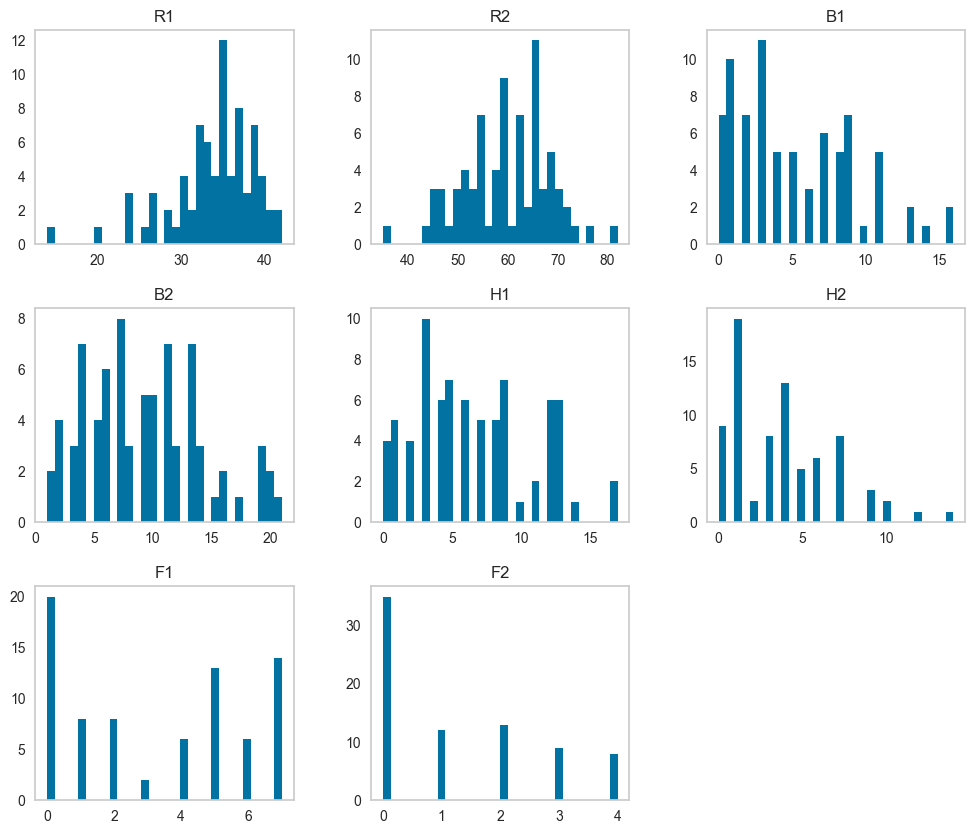

In [12]:
df.hist(bins = 30, figsize = (12,10), grid = False)
plt.show()

In [13]:
data = df.drop('Group', axis=1)
data

,R1,R2,B1,B2,H1,H2,F1,F2
0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0
1,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0
2,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0
4,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...
72,20.0,46.0,11.0,13.0,12.0,4.0,4.0,1.0
73,35.0,51.0,0.0,3.0,8.0,1.0,5.0,2.0
74,40.0,66.0,2.0,3.0,11.0,7.0,3.0,0.0
75,35.0,66.0,3.0,13.0,8.0,2.0,2.0,1.0


## Using PyCaret

We use PyCaret to automatically prepare the data for us (using the default settings of the setup function):

Seen as an **unsupervised classification problem**

**Features (X):** R1, R2, B1, B2, H1, H2, F1, F2<br>
**Labels (y):** Group (IBS or HC)

In [15]:
from pycaret.clustering import *

First intro to Kmeans with PyCaret (`exp_clu101`)

In [16]:
exp_clu101 = setup(data, normalize = True, session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(77, 8)"
2,Transformed data shape,"(77, 8)"
3,Numeric features,8
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [17]:
# num_clusters: int, default = 4
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1545,17.9228,1.8775,0,0,0


In [18]:
print(kmeans)

KMeans(n_clusters=4, random_state=123)


In [19]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch


In [20]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x1437c5440>,"make_scorer(silhouette_score, response_method=...",pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x1437c5760>,"make_scorer(calinski_harabasz_score, response_...",pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x1437c58a0>,"make_scorer(davies_bouldin_score, response_met...",pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x143567e20>,"make_scorer(homogeneity_score, response_method...",pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x143567ba0>,"make_scorer(adjusted_rand_score, response_meth...",pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x143567f60>,"make_scorer(completeness_score, response_metho...",pred,{},True,True,False


In [21]:
kmeans_df = assign_model(kmeans)
kmeans_df

,R1,R2,B1,B2,H1,H2,F1,F2,Cluster
0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0,Cluster 0
1,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0,Cluster 0
2,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0,Cluster 2
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,Cluster 3
4,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0,Cluster 2
...,...,...,...,...,...,...,...,...,...
72,20.0,46.0,11.0,13.0,12.0,4.0,4.0,1.0,Cluster 2
73,35.0,51.0,0.0,3.0,8.0,1.0,5.0,2.0,Cluster 1
74,40.0,66.0,2.0,3.0,11.0,7.0,3.0,0.0,Cluster 0
75,35.0,66.0,3.0,13.0,8.0,2.0,2.0,1.0,Cluster 0


In [22]:
kmean_results = assign_model(kmeans)
kmean_results.head()

,R1,R2,B1,B2,H1,H2,F1,F2,Cluster
0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0,Cluster 0
1,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0,Cluster 0
2,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0,Cluster 2
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,Cluster 3
4,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0,Cluster 2


In [25]:
plot_model(kmeans)

In [26]:
plot_model(kmeans, plot='tsne')

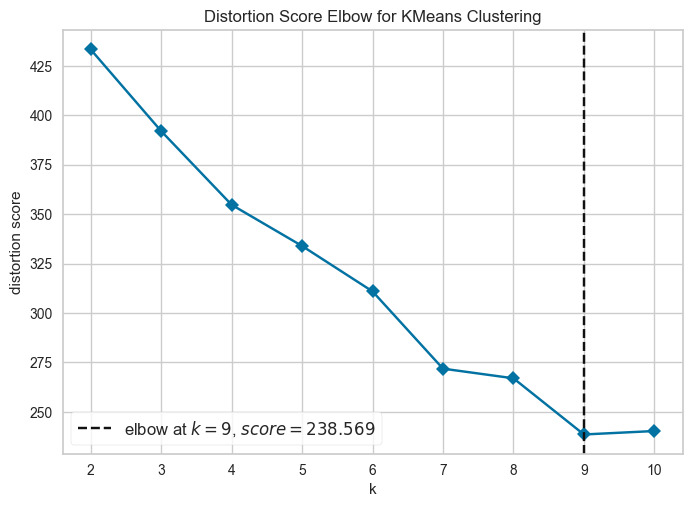

In [27]:
plot_model(kmeans, 'elbow')

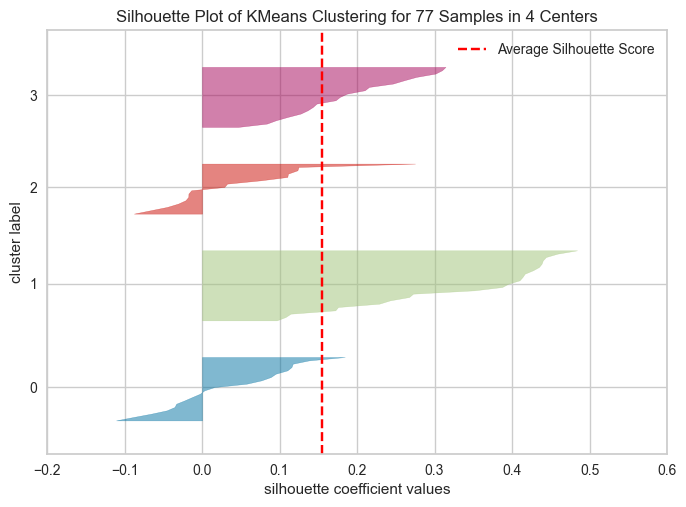

In [28]:
plot_model(kmeans, plot = 'silhouette')

In [29]:
plot_model(kmeans, plot = 'distribution')

In [30]:
plot_model(kmeans, plot = 'distribution', feature = 'F1')

In [31]:
plot_model(kmeans, plot = 'distribution', feature = 'R1')

In [33]:
evaluate_model(kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

The predict_model function is used to assign cluster labels to a new unseen dataset. We can use our trained kmeans model to predict the data stored in data_unseen (not available)

In [31]:

#unseen_predictions = predict_model(model = kmeans, data=data_unseen)
#unseen_predictions.head()

In [34]:
save_model(kmeans,'../models/KMeans_Model_20240721')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['R1', 'R2', 'B1', 'B2', 'H1', 'H2',
                                              'F1', 'F2'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('trained_model', KMeans(n_clusters=4, random_state=123))]),
 '../models/KMeans_Model_20240721.pkl')

In [35]:
saved_kmeans = load_model('../models/KMeans_Model_20240721')
#new_prediction = predict_model(saved_kmeans, data=data_unseen)
new_prediction = predict_model(saved_kmeans, data=data)
new_prediction.head()

Transformation Pipeline and Model Successfully Loaded


,R1,R2,B1,B2,H1,H2,F1,F2,Cluster
0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0,Cluster 0
1,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0,Cluster 0
2,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0,Cluster 2
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,Cluster 3
4,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0,Cluster 2


## Exploring our data with `K=3`

In [36]:
print(f'feat_names: {list(data.columns)}')

feat_names: ['R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2']


In [37]:
# num_clusters: int, default = 4
kmeans_3 = create_model('kmeans', num_clusters = 3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1574,21.1421,1.9990,0,0,0


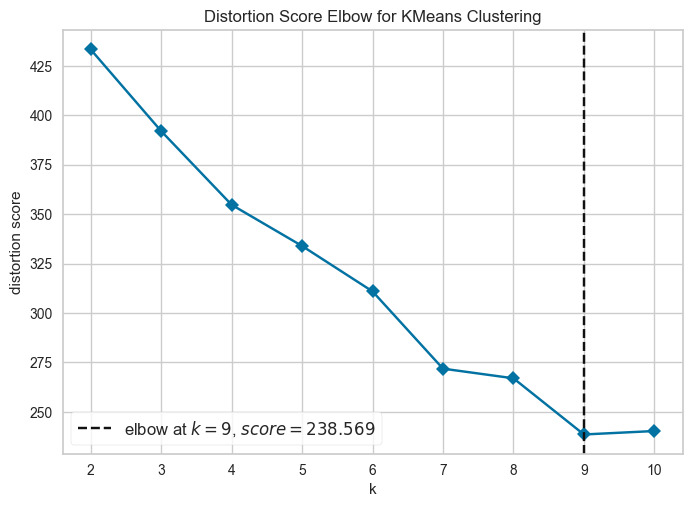

In [38]:
plot_model(kmeans_3, 'elbow')

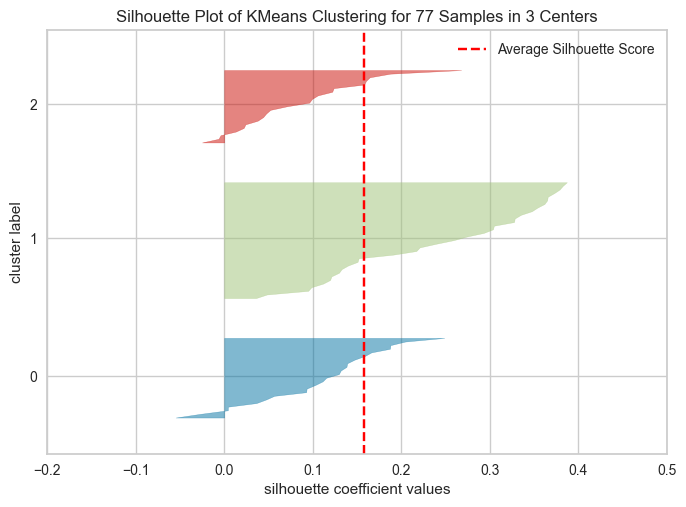

In [39]:
plot_model(kmeans_3, plot = 'silhouette')

In [40]:
plot_model(kmeans_3, plot='tsne')

In [41]:
evaluate_model(kmeans_3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [42]:
# Find cluster centroids

centroids = kmeans_3.cluster_centers_
centroids


array([[ 0.08582123, -0.08142342, -0.2777381 , -0.26233116,  0.5493817 ,
         0.24817897,  0.3161475 ,  0.09401012],
       [ 0.13633458,  0.33373553, -0.17284869, -0.5847442 , -0.75971085,
        -0.66405976, -0.8781408 , -0.79189044],
       [-0.30823472, -0.4352635 ,  0.57580864,  1.2061987 ,  0.59212756,
         0.7717073 ,  1.0336787 ,  1.1414359 ]], dtype=float32)

### K-means directly in `scikit-learn` (K=3)

In [43]:
X_orig = data
X_orig

,R1,R2,B1,B2,H1,H2,F1,F2
0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0
1,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0
2,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0
4,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...
72,20.0,46.0,11.0,13.0,12.0,4.0,4.0,1.0
73,35.0,51.0,0.0,3.0,8.0,1.0,5.0,2.0
74,40.0,66.0,2.0,3.0,11.0,7.0,3.0,0.0
75,35.0,66.0,3.0,13.0,8.0,2.0,2.0,1.0


In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Consider k-means clustering of X with k=K clusters
K = 3

# Make the X a numpy array
X_o = X_orig.to_numpy()

# Create a StandardScaler instance
scaler = StandardScaler()

# Scale the X to have mean 0 and variance 1
X_o_s = scaler.fit_transform(X_o)

# Create a KMeans instance with K clusters: model
model = KMeans(n_clusters=K, n_init=10, max_iter=300, random_state=42)

# Fit model to scaled points
model.fit(X_o_s)

# Determine the cluster labels of "new_points": labels
labels = model.predict(X_o_s)

# Print cluster labels of "new_points"
print(labels)

# Assign the cluster centers: centroids
centroids_s = model.cluster_centers_

# Re-scale the centroids to the original scale
centroids = scaler.inverse_transform(centroids_s)

centroids.round(2)

[0 0 2 2 1 2 1 0 0 0 2 2 0 0 2 2 2 0 2 0 0 0 0 0 2 0 0 2 2 0 2 2 0 2 0 0 1
 1 0 2 2 2 0 1 2 0 0 0 0 0 0 1 1 0 2 1 0 1 2 1 0 1 0 0 2 0 2 2 2 2 0 1 1 0
 0 0 0]


array([[35.5 , 63.26,  3.95,  6.5 ,  4.03,  1.89,  1.39,  0.37],
       [27.54, 50.92,  7.15,  8.77, 10.08,  4.62,  3.08,  0.85],
       [34.77, 58.88,  6.12, 13.27,  8.54,  6.04,  6.15,  2.77]])

In [45]:
# Add the cluster labels as a new column to the dataframe data
data_ext = data.copy()
data_ext['BGA'] = df_in['BGA']
data_ext['Cluster'] = labels.astype(int)
data_ext['Group'] = df_in['Group']
data_ext['Sex'] = df_in['Sex']
data_ext['Age'] = df_in['Age']
data_ext['IBS-SSS'] = df_in['IBS-SSS']
data_ext.head(5).T

,0,1,2,3,4
R1,37.0,36.0,35.0,37.0,30.0
R2,63.0,71.0,63.0,51.0,55.0
B1,3.0,8.0,14.0,8.0,7.0
B2,13.0,4.0,20.0,12.0,6.0
H1,1.0,2.0,7.0,7.0,13.0
H2,4.0,3.0,1.0,7.0,6.0
F1,3.0,5.0,6.0,7.0,1.0
F2,0.0,0.0,2.0,4.0,1.0
BGA,BGA_046,BGA_051,BGA_057,BGA_058,BGA_059
Cluster,0,0,2,2,1


In [46]:
print(data_ext['Group'].value_counts())
print(data_ext['Sex'].value_counts())

# Print values_conts for the cluster labels sorted by cluster
print(data_ext['Cluster'].value_counts().sort_index())



Group
IBS    49
HC     28
Name: count, dtype: int64
Sex
F    56
M    21
Name: count, dtype: int64
Cluster
0    38
1    13
2    26
Name: count, dtype: int64


In [47]:
n_IBS = data_ext['Group'].value_counts().iloc[0]
n_HC = data_ext['Group'].value_counts().iloc[1]

n_F = data_ext['Sex'].value_counts().iloc[0]
n_M = data_ext['Sex'].value_counts().iloc[1]

n_clu = [data_ext['Cluster'].value_counts().sort_index().iloc[i] for i in range(K)]

# Get number of IBS and HC in clusters 0, 1 and 2
n_IBS_clu = [len(data_ext[(data_ext['Cluster'] == i) & (data_ext['Group'] == 'IBS')]) for i in range(K)]
n_HC_clu = [len(data_ext[(data_ext['Cluster'] == i) & (data_ext['Group'] == 'HC')]) for i in range(K)]

# Get number of M and F in clusters 0, 1 and 2
n_M_clu = [len(data_ext[(data_ext['Cluster'] == i) & (data_ext['Sex'] == 'M')]) for i in range(K)]
n_F_clu = [len(data_ext[(data_ext['Cluster'] == i) & (data_ext['Sex'] == 'F')]) for i in range(K)]

n_clu

[38, 13, 26]

In [48]:
list(data.columns)

['R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2']

### Figure 5:  K-means centroides (K=3) and individual profiles with annotations

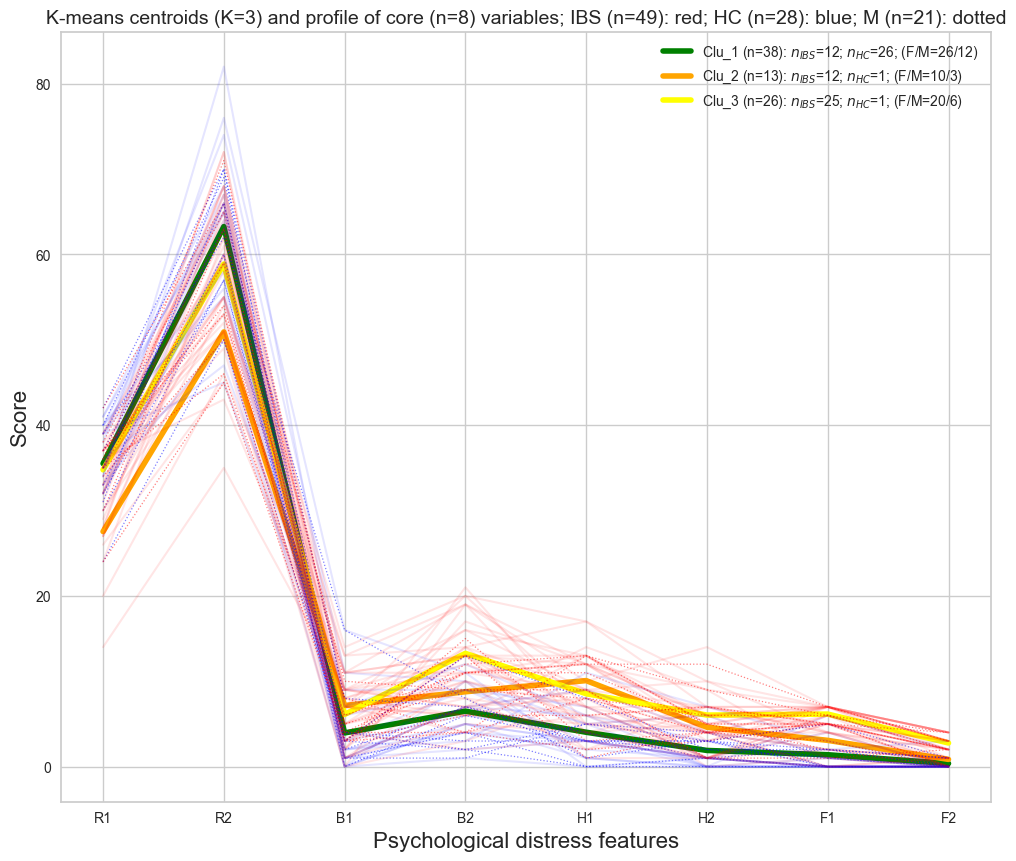

In [49]:
# Use columns R1, R2, B1, B2, H1, H2, F1, F2 as xticks
xticks = list(data.columns) 
n_var = len(xticks)

# Set the figure size
fig = plt.figure(figsize=(12, 10))

# Make a lineplot of the centroids and add all X_orig data to the lineplot
color_list = ['green', 'orange', 'yellow']
for i in range(K):
    plt.plot(xticks, centroids[i], label=f'Clu_{i+1} (n={n_clu[i]}): $n_{{IBS}}$={n_IBS_clu[i]}; $n_{{HC}}$={n_HC_clu[i]}; (F/M={n_F_clu[i]}/{n_M_clu[i]})', color=color_list[i], linewidth=4.0)

for i in range(len(X_o)):
    if data_ext['Group'][i] == 'IBS':
        if data_ext['Sex'][i] == 'M':
            plt.plot(xticks, X_o[i], color='red', alpha=0.5, linewidth=0.9, linestyle='dotted')
        else:
            plt.plot(xticks, X_o[i], color='red', alpha=0.1, linewidth=1.5)
    else:
        if data_ext['Sex'][i] == 'M':
            plt.plot(xticks, X_o[i], color='blue', alpha=0.5, linewidth=0.9, linestyle='dotted')
        else:
            plt.plot(xticks, X_o[i], color='blue', alpha=0.1, linewidth=1.5)
plt.legend()
plt.ylabel('Score', fontsize=16)
plt.xlabel('Psychological distress features', fontsize=16)
plt.title(f"K-means centroids (K={K}) and profile of core (n={n_var}) variables; IBS (n={n_IBS}): red; HC (n={n_HC}): blue; M (n={n_M}): dotted", fontsize=14)
plt.show()

# Save figure
fig.savefig('../figs/Fig_5_Kmeans_3_centroid_plots_with_annot.png')

### Table 4: K-means (K=3) results


NOTE: Cluster numbering starts at 0

In [50]:
# Compute descriptive statistics for the subjects allocated to each of the clusters for each feature R1, ..., F2
# Compute the mean, standard deviation, median, min, and max, for each feature for each cluster
# and store the results in a dataframe

# Create a dataframe to store the results
df_desc = pd.DataFrame(columns=['Cluster', 'n', 'feature', 'mean', 'std', 'median', 'min', 'max'])
data_clu3 = data.copy()
data_clu3['Cluster'] = data_ext['Cluster']

# Compute the descriptive statistics for each cluster for each feature
for i in range(K):
    # Get the data for the cluster i
    data_clu = pd.DataFrame()
    data_clu = data_clu3[data_clu3['Cluster'] == i]
    # Compute the descriptive statistics for the cluster i for each feature
    for j in range(n_var):
        # Compute the mean, standard deviation, median, min, max, 25th and 75th percentiles for the feature j for the cluster i
        mean = data_clu[xticks[j]].mean().round(2)
        std = data_clu[xticks[j]].std().round(2)
        median = data_clu[xticks[j]].median().round(2)
        min = data_clu[xticks[j]].min().round(2)
        max = data_clu[xticks[j]].max().round(2)
        # Append the results to the dataframe df_desc
        k=(i*n_var)+j
        df_desc.loc[k] = [i, len(data_clu), xticks[j],  mean, std, median, min, max]


df_desc

,Cluster,n,feature,mean,std,median,min,max
0,0,38,R1,35.50,3.60,35.0,28.0,42.0
1,0,38,R2,63.26,7.28,64.5,47.0,82.0
2,0,38,B1,3.95,4.21,2.5,0.0,16.0
3,0,38,B2,6.50,3.30,7.0,1.0,13.0
4,0,38,H1,4.03,2.98,3.0,0.0,11.0
5,0,38,H2,1.89,1.75,1.0,0.0,7.0
6,0,38,F1,1.39,1.84,0.5,0.0,6.0
7,0,38,F2,0.37,0.71,0.0,0.0,3.0
8,1,13,R1,27.54,6.35,27.0,14.0,37.0
9,1,13,R2,50.92,7.38,51.0,35.0,60.0


In [51]:
# Print to latex with 2 decimals
print(df_desc.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rrlrrrrr}
\toprule
Cluster & n & feature & mean & std & median & min & max \\
\midrule
0 & 38 & R1 & 35.50 & 3.60 & 35.00 & 28.00 & 42.00 \\
0 & 38 & R2 & 63.26 & 7.28 & 64.50 & 47.00 & 82.00 \\
0 & 38 & B1 & 3.95 & 4.21 & 2.50 & 0.00 & 16.00 \\
0 & 38 & B2 & 6.50 & 3.30 & 7.00 & 1.00 & 13.00 \\
0 & 38 & H1 & 4.03 & 2.98 & 3.00 & 0.00 & 11.00 \\
0 & 38 & H2 & 1.89 & 1.75 & 1.00 & 0.00 & 7.00 \\
0 & 38 & F1 & 1.39 & 1.84 & 0.50 & 0.00 & 6.00 \\
0 & 38 & F2 & 0.37 & 0.71 & 0.00 & 0.00 & 3.00 \\
1 & 13 & R1 & 27.54 & 6.35 & 27.00 & 14.00 & 37.00 \\
1 & 13 & R2 & 50.92 & 7.38 & 51.00 & 35.00 & 60.00 \\
1 & 13 & B1 & 7.15 & 3.46 & 7.00 & 2.00 & 13.00 \\
1 & 13 & B2 & 8.77 & 4.11 & 11.00 & 2.00 & 14.00 \\
1 & 13 & H1 & 10.08 & 3.68 & 11.00 & 4.00 & 17.00 \\
1 & 13 & H2 & 4.62 & 2.47 & 4.00 & 0.00 & 9.00 \\
1 & 13 & F1 & 3.08 & 2.06 & 4.00 & 0.00 & 7.00 \\
1 & 13 & F2 & 0.85 & 1.21 & 0.00 & 0.00 & 4.00 \\
2 & 26 & R1 & 34.77 & 4.03 & 35.00 & 24.00 & 42.00 \\
2 & 26 & R2 & 58.8

In [52]:
from collections import Counter

# Make lists of variables BGA, Age, Sex, IBS-SSS, Group for each of the three clusters
BGA_list = [list(data_ext[data_ext['Cluster'] == i]['BGA']) for i in range(K)] 
Age_list = [list(data_ext[data_ext['Cluster'] == i]['Age']) for i in range(K)] 
Sex_list = [list(data_ext[data_ext['Cluster'] == i]['Sex']) for i in range(K)] 
IBS_SSS_list = [list(data_ext[data_ext['Cluster'] == i]['IBS-SSS']) for i in range(K)] 
Group_list = [list(data_ext[data_ext['Cluster'] == i]['Group']) for i in range(K)]


for i in range(K):
    print(f'Cluster {i}: {Counter(Sex_list[i])}')
    print(f'Cluster {i}: {Counter(Group_list[i])}')
    print('\n')


Cluster 0: Counter({'F': 26, 'M': 12})
Cluster 0: Counter({'HC': 26, 'IBS': 12})


Cluster 1: Counter({'F': 10, 'M': 3})
Cluster 1: Counter({'IBS': 12, 'HC': 1})


Cluster 2: Counter({'F': 20, 'M': 6})
Cluster 2: Counter({'IBS': 25, 'HC': 1})




### Table 4 bottom part: Pair-wise effect size (Cohen)  [using Pingouin]
https://pingouin-stats.org/build/html/generated/pingouin.compute_effsize.html


In [53]:
# Comput effect sizes between clusteres for each of the 8 features R1, ..., F2

# Create a dataframe to store the results
df_eff_size = pd.DataFrame(columns=['Cluster_A', 'Cluster_B', 'feature', 'eff_size (Cohen)'])

# Compute the effect size for each feature between each pair of clusters
for i in range(K):
    for j in range(K):
        if i < j:
            for k in range(n_var):
                # Compute the effect size for the feature k between the clusters i and j
                eff_size = pg.compute_effsize(data_ext[data_ext['Cluster'] == i][xticks[k]], data_ext[data_ext['Cluster'] == j][xticks[k]], eftype='cohen')

                # Append the results to the dataframe df_eff_size
                df_eff_size.loc[(i*K+j)*n_var+k] = [i, j, xticks[k], round(eff_size, 2)]

# Reindex the dataframe df_eff_size
df_eff_size = df_eff_size.reset_index(drop=True)

# Add 1 to the cluster values to get the cluster numbers from 1 to K

df_eff_size['Cluster_A'] = df_eff_size['Cluster_A'] + 1
df_eff_size['Cluster_B'] = df_eff_size['Cluster_B'] + 1

df_eff_size

,Cluster_A,Cluster_B,feature,eff_size (Cohen)
0,1,2,R1,1.80
1,1,2,R2,1.69
2,1,2,B1,-0.79
3,1,2,B2,-0.65
4,1,2,H1,-1.91
5,1,2,H2,-1.39
6,1,2,F1,-0.89
7,1,2,F2,-0.55
8,1,3,R1,0.19
9,1,3,R2,0.58
